In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Mon Jan 22 23:05:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_notconst/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

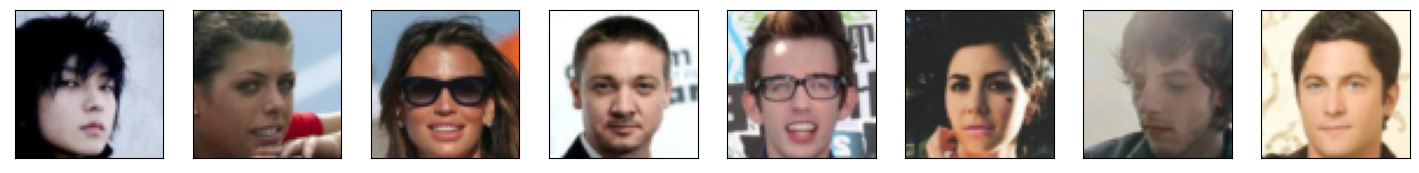

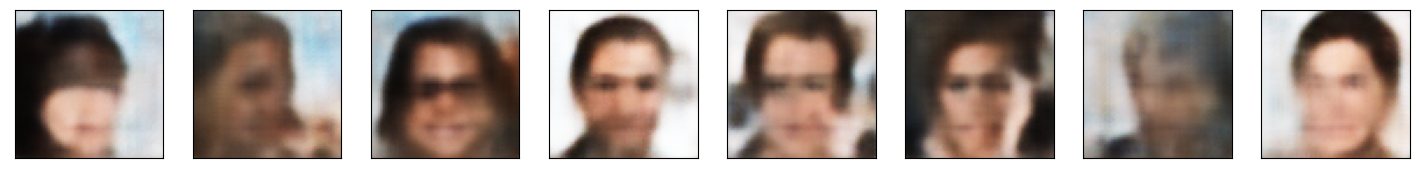

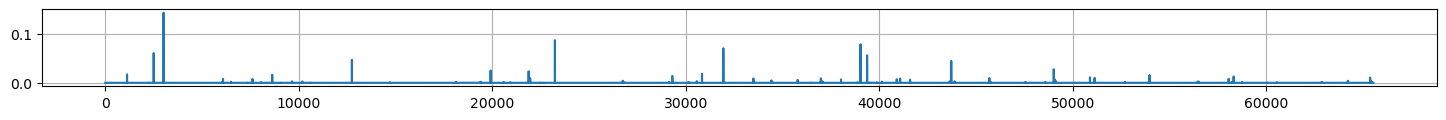

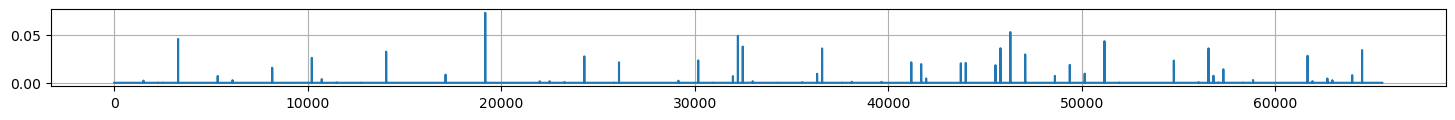

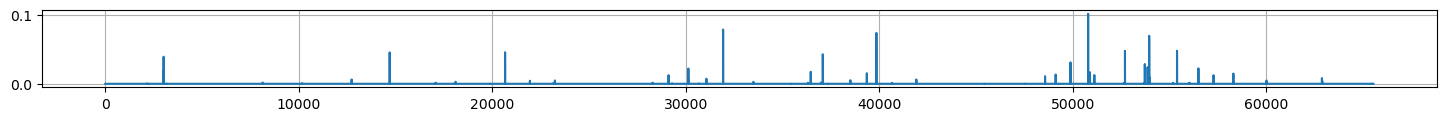

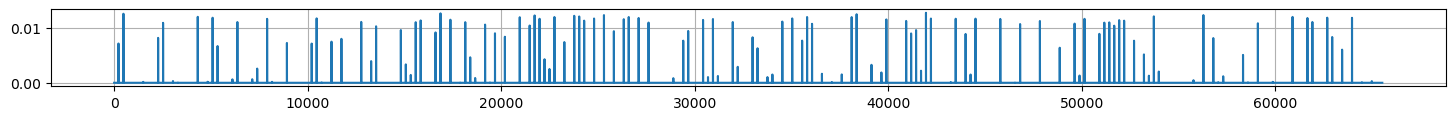

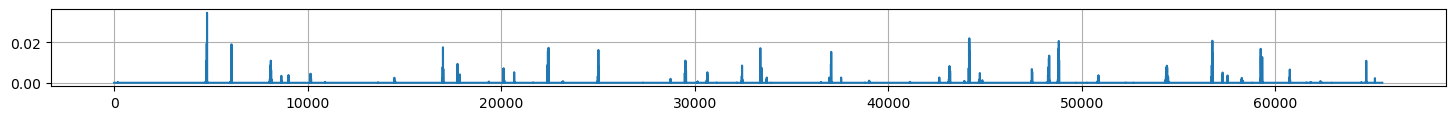

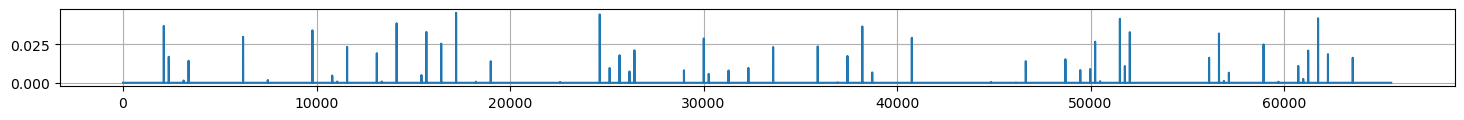

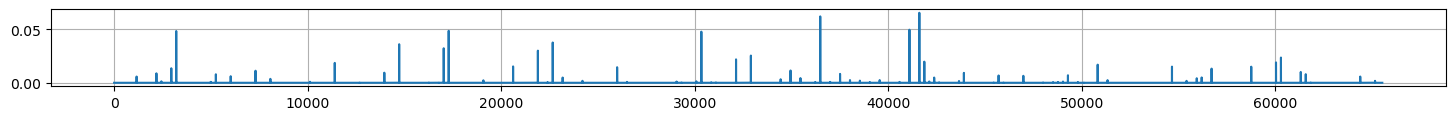

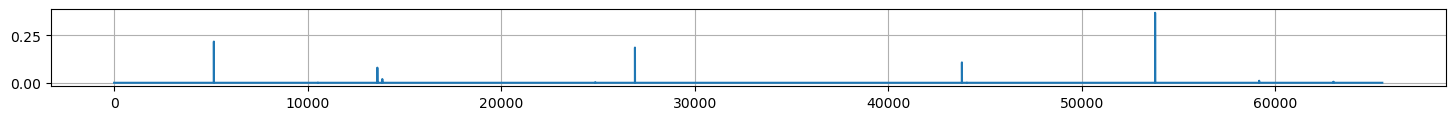

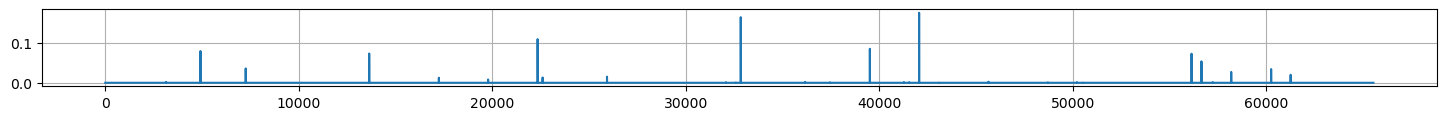

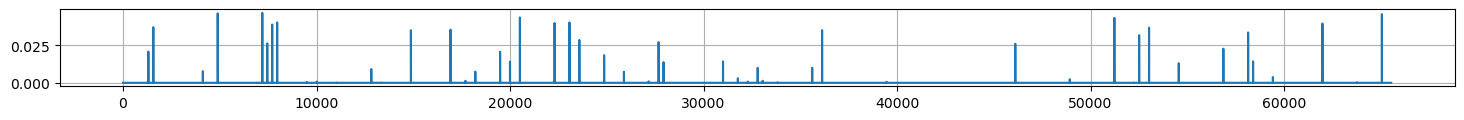

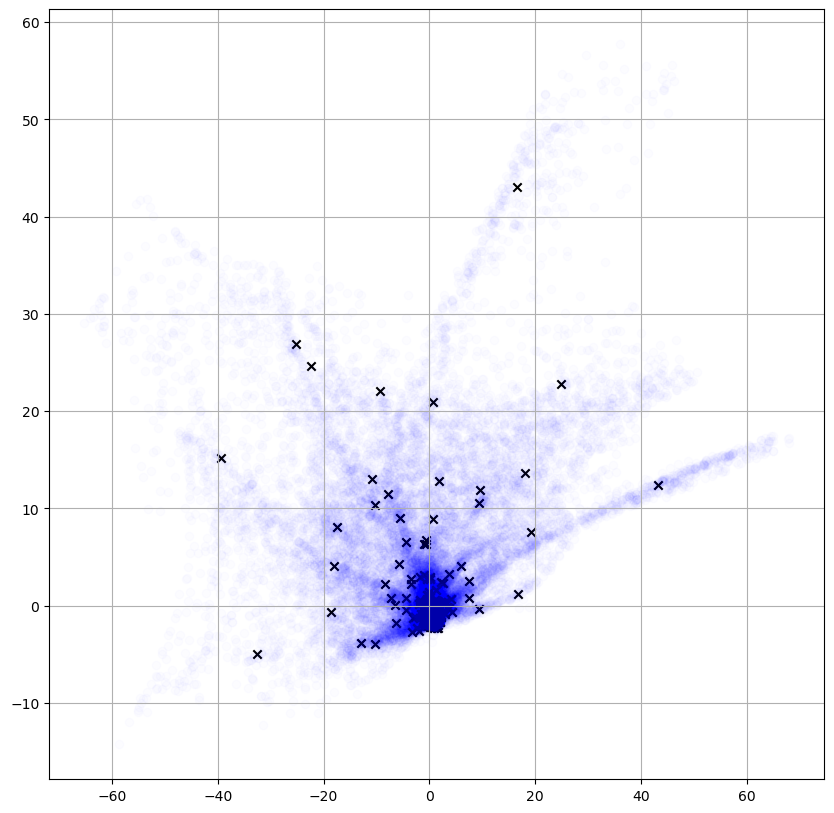

7001
lse_loss -73.38038635253906
commit_loss 0.3195355534553528
recon_loss 0.010709136724472046
7002
lse_loss -73.40704345703125
commit_loss 0.33367758989334106
recon_loss 0.011248994618654251
7003
lse_loss -73.45649719238281
commit_loss 0.3318326771259308
recon_loss 0.011167695745825768
7004
lse_loss -73.48338317871094
commit_loss 0.32801491022109985
recon_loss 0.011051049456000328
7005
lse_loss -73.46533966064453
commit_loss 0.32323572039604187
recon_loss 0.010938582941889763
7006
lse_loss -73.43299865722656
commit_loss 0.3151746988296509
recon_loss 0.01113638561218977
7007
lse_loss -73.45245361328125
commit_loss 0.33677810430526733
recon_loss 0.011229351162910461
7008
lse_loss -73.49285888671875
commit_loss 0.3321245312690735
recon_loss 0.01093926839530468
7009
lse_loss -73.46802520751953
commit_loss 0.3381883502006531
recon_loss 0.01141427643597126
7010
lse_loss -73.51734924316406
commit_loss 0.31888753175735474
recon_loss 0.01110970787703991
7011
lse_loss -73.53448486328125
commit

7087
lse_loss -73.97798156738281
commit_loss 0.3352016508579254
recon_loss 0.010658642277121544
7088
lse_loss -74.03197479248047
commit_loss 0.3272230327129364
recon_loss 0.010900100693106651
7089
lse_loss -74.04332733154297
commit_loss 0.3311876058578491
recon_loss 0.01129823923110962
7090
lse_loss -74.0042495727539
commit_loss 0.3338881731033325
recon_loss 0.011433927342295647
7091
lse_loss -74.08686828613281
commit_loss 0.333867609500885
recon_loss 0.010874751023948193
7092
lse_loss -74.01152801513672
commit_loss 0.3305128812789917
recon_loss 0.010724618099629879
7093
lse_loss -74.03455352783203
commit_loss 0.31941404938697815
recon_loss 0.011397945694625378
7094
lse_loss -74.10037231445312
commit_loss 0.3220495581626892
recon_loss 0.010921615175902843
7095
lse_loss -74.0885009765625
commit_loss 0.3300042748451233
recon_loss 0.010749919340014458
7096
lse_loss -74.00883483886719
commit_loss 0.33209991455078125
recon_loss 0.011524646542966366
7097
lse_loss -74.0183334350586
commit_los

7173
lse_loss -74.63562774658203
commit_loss 0.324867844581604
recon_loss 0.010700414888560772
7174
lse_loss -74.51101684570312
commit_loss 0.3181108236312866
recon_loss 0.011077240109443665
7175
lse_loss -74.36634063720703
commit_loss 0.33448895812034607
recon_loss 0.011359967291355133
7176
lse_loss -74.62701416015625
commit_loss 0.31929728388786316
recon_loss 0.011143630370497704
7177
lse_loss -74.633056640625
commit_loss 0.321121484041214
recon_loss 0.010954858735203743
7178
lse_loss -74.59980773925781
commit_loss 0.32532835006713867
recon_loss 0.01096932403743267
7179
lse_loss -74.60729217529297
commit_loss 0.33007746934890747
recon_loss 0.010997223667800426
7180
lse_loss -74.61478424072266
commit_loss 0.3395956754684448
recon_loss 0.011289805173873901
7181
lse_loss -74.63742065429688
commit_loss 0.31938308477401733
recon_loss 0.011364477686583996
7182
lse_loss -74.55635833740234
commit_loss 0.32960790395736694
recon_loss 0.01094858255237341
7183
lse_loss -74.66159057617188
commit_

7259
lse_loss -75.02139282226562
commit_loss 0.3154734969139099
recon_loss 0.010793200694024563
7260
lse_loss -75.03085327148438
commit_loss 0.3244665265083313
recon_loss 0.011945056729018688
7261
lse_loss -75.10346984863281
commit_loss 0.3255268931388855
recon_loss 0.011191091500222683
7262
lse_loss -75.15953826904297
commit_loss 0.31683671474456787
recon_loss 0.011224895715713501
7263
lse_loss -75.15616607666016
commit_loss 0.3334153890609741
recon_loss 0.011220584623515606
7264
lse_loss -74.9149398803711
commit_loss 0.3477265536785126
recon_loss 0.011521290987730026
7265
lse_loss -75.17141723632812
commit_loss 0.323734849691391
recon_loss 0.011101093143224716
7266
lse_loss -75.10566711425781
commit_loss 0.3367546498775482
recon_loss 0.011011652648448944
7267
lse_loss -75.07626342773438
commit_loss 0.3360123038291931
recon_loss 0.011678531765937805
7268
lse_loss -75.20463562011719
commit_loss 0.3264331817626953
recon_loss 0.010814438574016094
7269
lse_loss -75.08525848388672
commit_l

7345
lse_loss -75.7287368774414
commit_loss 0.3169739842414856
recon_loss 0.011487895622849464
7346
lse_loss -75.67034912109375
commit_loss 0.3204057514667511
recon_loss 0.01105954498052597
7347
lse_loss -75.61112213134766
commit_loss 0.3330874443054199
recon_loss 0.011175816878676414
7348
lse_loss -75.71236419677734
commit_loss 0.32825568318367004
recon_loss 0.010263718664646149
7349
lse_loss -75.62797546386719
commit_loss 0.3307945728302002
recon_loss 0.011849570088088512
7350
lse_loss -75.71907043457031
commit_loss 0.3198414444923401
recon_loss 0.011302322149276733
7351
lse_loss -75.66487884521484
commit_loss 0.31955355405807495
recon_loss 0.01100355014204979
7352
lse_loss -75.63468933105469
commit_loss 0.31937935948371887
recon_loss 0.011138282716274261
7353
lse_loss -75.70565795898438
commit_loss 0.31283634901046753
recon_loss 0.010836413130164146
7354
lse_loss -75.75850677490234
commit_loss 0.32630157470703125
recon_loss 0.010598018765449524
7355
lse_loss -75.66056823730469
commi

7431
lse_loss -76.2254409790039
commit_loss 0.3168667256832123
recon_loss 0.01044607162475586
7432
lse_loss -76.18946838378906
commit_loss 0.3261374831199646
recon_loss 0.010909373871982098
7433
lse_loss -76.28385162353516
commit_loss 0.33136630058288574
recon_loss 0.011090606451034546
7434
lse_loss -76.2120132446289
commit_loss 0.33620530366897583
recon_loss 0.0113957729190588
7435
lse_loss -76.17488098144531
commit_loss 0.321233868598938
recon_loss 0.011456048116087914
7436
lse_loss -76.136474609375
commit_loss 0.30657705664634705
recon_loss 0.010937249287962914
7437
lse_loss -76.16743469238281
commit_loss 0.3387152850627899
recon_loss 0.011171008460223675
7438
lse_loss -76.20572662353516
commit_loss 0.32845833897590637
recon_loss 0.011397836729884148
7439
lse_loss -76.25968933105469
commit_loss 0.3216626048088074
recon_loss 0.0117064593359828
7440
lse_loss -76.19668579101562
commit_loss 0.3285590708255768
recon_loss 0.01163723599165678
7441
lse_loss -76.32859802246094
commit_loss 0.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            writer.add_scalar('log_sigma', model.latent.log_sigma.item(), step)
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')